# Prediction demand of bikes at each bike station at different time of the day
index = start_date, start_station_id
time period = { period 1: 1-3, 
                period 2: 4-6, 
                period 3: 7-9, 
                period 4: 10-12, 
                period 5: 13-15, 
                period 6: 16-18, 
                period 7: 19-21,
                period 8: 22-24}
peak = {period 3, period 6}

### Load the packages

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import xgboost as xgb
from geopy.distance import geodesic
# from scipy.stats.stats import pearsonr  

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error

# trip data

In [3]:
# import trip data
trip = pd.read_csv("trip.csv")

In [4]:
# Change trip duration from seconds to minutes
trip.duration /= 60

In [5]:
# remove major outliers: trips longer than 6 hours. This will remove less than 0.5% of the data.
trip['duration'].quantile(0.995)
trip = trip[trip.duration <= 360]

In [6]:
# convert to datetime, seperate date and hour
# map hour to 8 time periods
trip["start_date2"] = pd.to_datetime(trip.start_date, format='%m/%d/%Y %H:%M').dt.date
trip["start_time"]=pd.to_datetime(trip.start_date, format='%m/%d/%Y %H:%M').dt.hour
trip["start_time_period"]=trip.start_time.map(lambda x: "period " + str((x+2)//3) )

- period 1: 1-3 
- period 2: 4-6 
- period 3: 7-9 (AM peak)
- period 4: 10-12
- period 5: 13-15 
- period 6: 16-18 (PM peak)
- period 7: 19-21
- period 8: 22-24

In [8]:
trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,start_date2,start_time,start_time_period
0,4576,1.050000,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127,2013-08-29,14,period 5
1,4607,1.166667,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138,2013-08-29,14,period 5
2,4130,1.183333,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214,2013-08-29,10,period 4
3,4251,1.283333,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060,2013-08-29,11,period 4
4,4299,1.383333,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103,2013-08-29,12,period 4


In [9]:
# summarize count(trips) and sum(duration) by date, station, start_time_period
# this will be data frame used for training
trip2 = trip.groupby(['start_date2','start_station_id','start_time_period']).agg({"id": "count", "duration":"sum"}).reset_index()
trip2.rename(columns = {'start_date2':'date', 'start_station_id':'station', 'id':'trips', }, inplace = True)
trip2.head()

,date,station,start_time_period,trips,duration
0,2013-08-29,2,period 5,1,26.333333
1,2013-08-29,2,period 6,1,8.716667
2,2013-08-29,2,period 7,3,38.150000
3,2013-08-29,3,period 5,1,2.766667
4,2013-08-29,3,period 6,1,11.733333


In [10]:
# count of trips starting from each station at each time period of each day:
# min=1, max=87, mean=2
trip2.describe()

,station,trips,duration
count,161707.000000,161707.000000,161707.000000
mean,51.582529,4.123953,56.581931
std,21.262277,5.401237,104.266902
min,2.000000,1.000000,1.000000
25%,41.000000,1.000000,9.800000
50%,57.000000,2.000000,23.216667
75%,68.000000,5.000000,58.283333
max,84.000000,87.000000,2731.066667


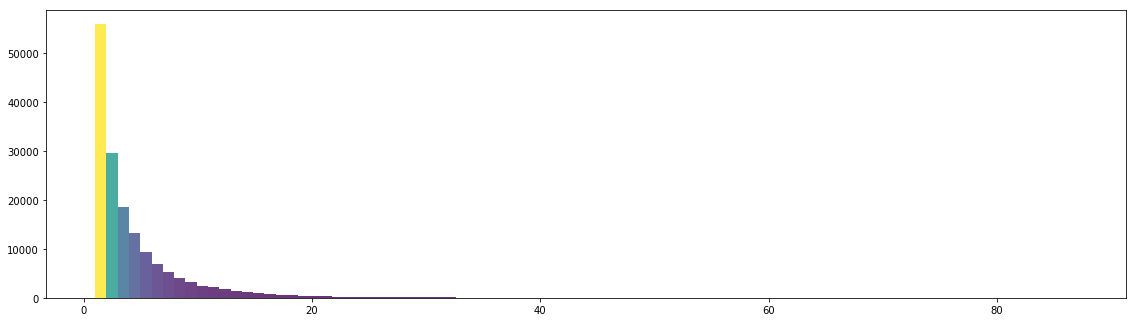

In [55]:
# plot count of trips
# it follows a power law distribution with long tail:
#    - most stations are used <10 times in a 3 hour interval, there is no shortage problem
#    - some stations have high demand
#    - so our objective should be: to ensure sufficient bike supply in high demand staions and time periods

plt.figure(figsize=(15,4))
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
n_bins=87
N, bins, patches = plt.hist(trip2.trips, bins=n_bins, alpha=0.8)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
plt.show()

In [56]:
# leave out duration for now
trip2 = trip2.iloc[:,0:4]
trip2.head()

,date,station,start_time_period,trips
0,2013-08-29,2,period 5,1
1,2013-08-29,2,period 6,1
2,2013-08-29,2,period 7,3
3,2013-08-29,3,period 5,1
4,2013-08-29,3,period 6,1


In [57]:
trip2.shape

(161707, 4)

#  
#  
# Weather data

In [58]:
# load weather data
weather = pd.read_csv("weather.csv")
weather.shape

(3665, 24)

In [61]:
# # convert to datetime, keep date only
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y').dt.date

In [62]:
#It seems we have one entry per zip code
#We need to map the stations to one of the five zip codes later
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [59]:
# weather data has a lot of missing values
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

### tidy up events

In [64]:
# some weather events are in capital, some are not
# nan should mean normal weather, no special events
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'], dtype=object)

In [65]:
weather.loc[weather.events == 'rain', 'events'] = "Rain"
weather.loc[weather.events.isnull(), 'events'] = "Normal"
events = pd.get_dummies(weather.events)
weather = weather.merge(events, left_index = True, right_index = True)
weather = weather.drop(['events'],1)

### tidy up max_gust_speed_mph
it has the most missing values

In [66]:
# For each value of max_wind, find the median max_gust and use that to fill the null values of max_gust
weather.loc[weather.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] = weather.groupby('max_wind_Speed_mph').max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

### tidy up precipitation_inches

In [67]:
# Change this feature from a string to numeric.
# Use errors = 'coerce' because some values currently equal 'T' and we want them to become NAs.
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors = 'coerce')

In [68]:
# Change null values to the median, of values > 0, because T, I think, means True. 
# Therefore we want to find the median amount of precipitation on days when it rained.
weather.loc[weather.precipitation_inches.isnull(), 
            'precipitation_inches'] = weather[weather.precipitation_inches.notnull()].precipitation_inches.median()

### impute other missing values
- fill with median
- fill with 0

In [70]:
# impute other missing value with median first (to be improved later)
weather.loc[weather.max_temperature_f.isnull(), 'max_temperature_f'] = weather[weather.max_temperature_f.notnull()].max_temperature_f.median()
weather.loc[weather.mean_temperature_f.isnull(), 'mean_temperature_f'] = weather[weather.mean_temperature_f.notnull()].mean_temperature_f.median()
weather.loc[weather.min_temperature_f.isnull(), 'min_temperature_f'] = weather[weather.min_temperature_f.notnull()].min_temperature_f.median()

weather.loc[weather.max_dew_point_f.isnull(), 'max_dew_point_f'] = weather[weather.max_dew_point_f.notnull()].max_dew_point_f.median()
weather.loc[weather.mean_dew_point_f.isnull(), 'mean_dew_point_f'] = weather[weather.mean_dew_point_f.notnull()].mean_dew_point_f.median()
weather.loc[weather.min_dew_point_f.isnull(), 'min_dew_point_f'] = weather[weather.min_dew_point_f.notnull()].min_dew_point_f.median()

weather.loc[weather.max_humidity.isnull(), 'max_humidity'] = weather[weather.max_humidity.notnull()].max_humidity.median()
weather.loc[weather.mean_humidity.isnull(), 'mean_humidity'] = weather[weather.mean_humidity.notnull()].mean_humidity.median()
weather.loc[weather.min_humidity.isnull(), 'min_humidity'] = weather[weather.min_humidity.notnull()].min_humidity.median()

weather.loc[weather.max_visibility_miles.isnull(), 'max_visibility_miles'] = weather[weather.max_visibility_miles.notnull()].max_visibility_miles.median()
weather.loc[weather.mean_visibility_miles.isnull(), 'mean_visibility_miles'] = weather[weather.mean_visibility_miles.notnull()].mean_visibility_miles.median()
weather.loc[weather.min_visibility_miles.isnull(), 'min_visibility_miles'] = weather[weather.min_visibility_miles.notnull()].min_visibility_miles.median()

In [71]:
weather = weather.fillna(0)

In [72]:
# check there is no more null
weather.isnull().sum()

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
zip_code                          0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm           

In [75]:
# weather2 will be used for training later
weather2 = weather
weather2.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,zip_code,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,28.0,0.0,4.0,286.0,94107,0,0,1,0,0
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,35.0,0.0,2.0,291.0,94107,0,0,1,0,0
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,31.0,0.0,4.0,284.0,94107,0,0,1,0,0
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,29.0,0.0,4.0,284.0,94107,0,0,1,0,0
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,30.0,0.0,6.0,277.0,94107,0,0,1,0,0


#  
#  

# Station data
**original attributes in dataset:**
- station id: `id`
- station name: `name`
- station coordinates: `lat`, `long`
- dock count: `dock_count`
- city: `city`
- Installation date: `installation_date`

**added attributes:**
- coordinate tuple: `coords`
- mapped weather zip code: `weather_zip`

In [76]:
# load stations data from csv
stations = pd.read_csv("station.csv")
stations

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013
5,7,Paseo de San Antonio,37.333798,-121.886943,15,San Jose,8/7/2013
6,8,San Salvador at 1st,37.330165,-121.885831,15,San Jose,8/5/2013
7,9,Japantown,37.348742,-121.894715,15,San Jose,8/5/2013
8,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,8/6/2013
9,11,MLK Library,37.335885,-121.885660,19,San Jose,8/6/2013


In [77]:
# stations are distributed across 5 cities in Bay area
# most stations are in San Francisco, followed by San Jose
stations.city.value_counts()

San Francisco    35
San Jose         16
Redwood City      7
Mountain View     7
Palo Alto         5
Name: city, dtype: int64

In [78]:
# there are also 5 unique zip code in weather data
# I suppose 1 zip code corresponds to 1 city
# we are going to map the stations to the nearest weather zip code to prove this
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

**coordinate (lat, long) of each zip code**
- 94107: 37.7618242, -122.3985871
- 94063: 37.5021585, -122.2086579
- 94301: 37.4457966, -122.1575745
- 94041: 37.386812, -122.0751549
- 95113: 37.3326639, -121.8918364

source: https://www.freemaptools.com/convert-us-zip-code-to-lat-lng.htm

In [79]:
coords_1 = (37.7618242, -122.3985871)  # 94107
coords_2 = (37.5021585, -122.2086579)  # 94063
coords_3 = (37.4457966, -122.1575745)  # 94301
coords_4 = (37.3868120, -122.0751549)  # 94041
coords_5 = (37.3326639, -121.8918364)  # 95113

In [80]:
# combine 'lat' and 'long' into a tuple to be used for distance calculation
stations["coords"] = list(zip(stations.lat, stations.long))
stations.head()

,id,name,lat,long,dock_count,city,installation_date,coords
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,"(37.329732, -121.901782)"
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,"(37.330698, -121.888979)"
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,"(37.333988, -121.894902)"
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,"(37.331415, -121.8932)"
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,"(37.336721, -121.894074)"


In [81]:
# find the nearest weather zip code using geodesic distance (unit: km)
# https://geopy.readthedocs.io/en/stable/
stations["weather_zip"] = stations.coords.apply(lambda x: np.argmin((geodesic(coords_1, x).km,
                                                                     geodesic(coords_2, x).km,
                                                                     geodesic(coords_3, x).km,
                                                                     geodesic(coords_4, x).km,
                                                                     geodesic(coords_5, x).km)))

In [82]:
# all stations are now mapped to one of the 5 weather zip areas, using an index (0,4) representing each area
# we can see that each city corresponds to one index: 
#    0-San Francisco, 1-Redwood City, 2-Palo Alto, 3-Mountain View, 4-San Jose
# we can use either station city name or weather zip to map weather data to trips
stations

,id,name,lat,long,dock_count,city,installation_date,coords,weather_zip
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,"(37.329732, -121.901782)",4
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,"(37.330698, -121.888979)",4
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,"(37.333988, -121.894902)",4
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,"(37.331415, -121.8932)",4
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,"(37.336721, -121.894074)",4
5,7,Paseo de San Antonio,37.333798,-121.886943,15,San Jose,8/7/2013,"(37.333798, -121.886943)",4
6,8,San Salvador at 1st,37.330165,-121.885831,15,San Jose,8/5/2013,"(37.330165, -121.885831)",4
7,9,Japantown,37.348742,-121.894715,15,San Jose,8/5/2013,"(37.348742, -121.894715)",4
8,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,8/6/2013,"(37.337391, -121.886995)",4
9,11,MLK Library,37.335885,-121.885660,19,San Jose,8/6/2013,"(37.335885, -121.88566)",4


In [83]:
# use a dictionary to map weather area index back to weather zip code
dic = {0:94107, 1:94063, 2:94301, 3:94041, 4:95113}
stations.replace({"weather_zip": dic}, inplace=True)

In [84]:
stations.head()

,id,name,lat,long,dock_count,city,installation_date,coords,weather_zip
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,"(37.329732, -121.901782)",95113
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,"(37.330698, -121.888979)",95113
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,"(37.333988, -121.894902)",95113
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,"(37.331415, -121.8932)",95113
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,"(37.336721, -121.894074)",95113


In [85]:
# installation date is not important for our prediction: if a station is not installed a certain date, 
# there will be no trip data for that station on that date.
# we also don't need coordinates any more, we'll drop these columns
stations2 = stations.drop(['installation_date', 'lat', 'long', 'coords'],1)

#  
#  
# merge all data into train
1. merge trip with stations, using station id as the key
2. merge trip-station with weather, using date and weather_zip as the key

In [99]:
# merge trip data with station data
train = pd.merge(trip2, stations2, left_on=['station'], right_on=['id'])

# merge again with weather data
train = pd.merge(train, weather2, left_on=['date', 'weather_zip'], right_on=['date', 'zip_code'])

In [100]:
train = train.drop(['id','weather_zip','zip_code'], 1)
train.head()

,date,station,start_time_period,trips,name,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29,2,period 5,1,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0
1,2013-08-29,2,period 6,1,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0
2,2013-08-29,2,period 7,3,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0
3,2013-08-29,3,period 5,1,San Jose Civic Center,15,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0
4,2013-08-29,3,period 6,1,San Jose Civic Center,15,San Jose,81.0,72.0,63.0,...,7.0,24.0,0.0,4.0,320.0,0,0,1,0,0


#  
#  
# Special Dates

In [107]:
# Find all of the holidays during our time span
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.date.min(), end=train.date.max())
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date
holidays

array([datetime.date(2013, 9, 2), datetime.date(2013, 10, 14),
       datetime.date(2013, 11, 11), datetime.date(2013, 11, 28),
       datetime.date(2013, 12, 25), datetime.date(2014, 1, 1),
       datetime.date(2014, 1, 20), datetime.date(2014, 2, 17),
       datetime.date(2014, 5, 26), datetime.date(2014, 7, 4),
       datetime.date(2014, 9, 1), datetime.date(2014, 10, 13),
       datetime.date(2014, 11, 11), datetime.date(2014, 11, 27),
       datetime.date(2014, 12, 25), datetime.date(2015, 1, 1),
       datetime.date(2015, 1, 19), datetime.date(2015, 2, 16),
       datetime.date(2015, 5, 25), datetime.date(2015, 7, 3)], dtype=object)

In [110]:
#Find all of the business days in our time span
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=train.date.min(), end=train.date.max(), freq=us_bd)
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
business_days

array([datetime.date(2013, 8, 29), datetime.date(2013, 8, 30),
       datetime.date(2013, 9, 3), datetime.date(2013, 9, 4),
       datetime.date(2013, 9, 5), datetime.date(2013, 9, 6),
       datetime.date(2013, 9, 9), datetime.date(2013, 9, 10),
       datetime.date(2013, 9, 11), datetime.date(2013, 9, 12),
       datetime.date(2013, 9, 13), datetime.date(2013, 9, 16),
       datetime.date(2013, 9, 17), datetime.date(2013, 9, 18),
       datetime.date(2013, 9, 19), datetime.date(2013, 9, 20),
       datetime.date(2013, 9, 23), datetime.date(2013, 9, 24),
       datetime.date(2013, 9, 25), datetime.date(2013, 9, 26),
       datetime.date(2013, 9, 27), datetime.date(2013, 9, 30),
       datetime.date(2013, 10, 1), datetime.date(2013, 10, 2),
       datetime.date(2013, 10, 3), datetime.date(2013, 10, 4),
       datetime.date(2013, 10, 7), datetime.date(2013, 10, 8),
       datetime.date(2013, 10, 9), datetime.date(2013, 10, 10),
       datetime.date(2013, 10, 11), datetime.date(2013, 10,

In [113]:
# map date to business_day and holiday, convert to binary variables
train['business_day'] = train.date.isin(business_days)
train['holiday'] = train.date.isin(holidays)
#Convert True to 1 and False to 0
train.business_day = train.business_day.map(lambda x: 1 if x == True else 0)
train.holiday = train.holiday.map(lambda x: 1 if x == True else 0)

In [114]:
#Convert date to the important features, year, month, weekday (0 = Monday, 1 = Tuesday...)
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['weekday'] = pd.to_datetime(train['date']).dt.weekday
train.head()

,date,station,start_time_period,trips,name,dock_count,city,max_temperature_f,mean_temperature_f,min_temperature_f,...,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,business_day,holiday,year,month,weekday
0,2013-08-29,2,period 5,1,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3
1,2013-08-29,2,period 6,1,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3
2,2013-08-29,2,period 7,3,San Jose Diridon Caltrain Station,27,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3
3,2013-08-29,3,period 5,1,San Jose Civic Center,15,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3
4,2013-08-29,3,period 6,1,San Jose Civic Center,15,San Jose,81.0,72.0,63.0,...,0,0,1,0,0,1,0,2013,8,3


In [115]:
train.shape

(161707, 38)

In [116]:
# here's the list of 38 columns in train
list(train)

['date',
 'station',
 'start_time_period',
 'trips',
 'name',
 'dock_count',
 'city',
 'max_temperature_f',
 'mean_temperature_f',
 'min_temperature_f',
 'max_dew_point_f',
 'mean_dew_point_f',
 'min_dew_point_f',
 'max_humidity',
 'mean_humidity',
 'min_humidity',
 'max_sea_level_pressure_inches',
 'mean_sea_level_pressure_inches',
 'min_sea_level_pressure_inches',
 'max_visibility_miles',
 'mean_visibility_miles',
 'min_visibility_miles',
 'max_wind_Speed_mph',
 'mean_wind_speed_mph',
 'max_gust_speed_mph',
 'precipitation_inches',
 'cloud_cover',
 'wind_dir_degrees',
 'Fog',
 'Fog-Rain',
 'Normal',
 'Rain',
 'Rain-Thunderstorm',
 'business_day',
 'holiday',
 'year',
 'month',
 'weekday']

#  
#  
# Train the model

In [117]:
# convert categorical variables to one-hot representation, as required by scikit learn
start_time_period = pd.get_dummies(train.start_time_period)
station = pd.get_dummies(train.station)
city = pd.get_dummies(train.city)

In [118]:
train = train.merge(start_time_period, left_index = True, right_index = True)
train = train.merge(city, left_index = True, right_index = True)
train = train.merge(station, left_index = True, right_index = True)

In [120]:
train = train.drop(['start_time_period','station','city','name','date'],1)

In [122]:
train.describe()

,trips,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,...,77,80,82,83,84,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose
count,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,...,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000,161707.000000
mean,4.123953,18.671183,69.609139,61.096421,52.162188,52.715121,49.009690,44.962710,85.475830,67.653355,...,0.024050,0.003760,0.015998,0.001837,0.006067,0.056151,0.027581,0.015528,0.770220,0.130520
std,5.401237,4.076802,7.669041,6.413219,6.614520,5.822650,6.933592,8.651336,8.592631,10.219602,...,0.153204,0.061203,0.125468,0.042817,0.077652,0.230214,0.163769,0.123641,0.420692,0.336876
min,1.000000,11.000000,46.000000,38.000000,25.000000,20.000000,13.000000,2.000000,24.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,15.000000,64.000000,57.000000,48.000000,49.000000,46.000000,41.000000,83.000000,63.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,19.000000,69.000000,61.000000,53.000000,53.000000,49.000000,46.000000,86.000000,69.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,5.000000,23.000000,74.000000,66.000000,57.000000,57.000000,55.000000,52.000000,92.000000,73.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,87.000000,27.000000,102.000000,84.000000,75.000000,68.000000,65.000000,63.000000,100.000000,96.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [123]:
labels = train.iloc[:,0]
labels.head()

0    1
1    1
2    3
3    1
4    1
Name: trips, dtype: int64

In [124]:
features = train.iloc[:,1:]
features.head()

,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,77,80,82,83,84,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose
0,27,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,1
1,27,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,1
2,27,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,1
3,15,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,1
4,15,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,0,0,0,0,0,0,0,0,0,1


In [125]:
# split into training 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state = 2)

In [162]:
# our data has 116 features
# training data has 129365 samples
# test data has 32342 samples
print(X_train.shape)
print(X_test.shape)

(129365, 116)
(32342, 118)


In [126]:
#10 fold cross validation. Multiply by -1 to make values positive.
#Used median absolute error to learn how many trips my predictions are off by.

def scoring(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=1, scoring = 'neg_median_absolute_error')
    print (np.median(scores) * -1)

In [128]:
rfr = RandomForestRegressor(n_estimators = 10, # to be tuned
                            min_samples_leaf = 3,
                            random_state = 2)
scoring(rfr)

0.877272727273


In [129]:
gbr = GradientBoostingRegressor(learning_rate = 0.12,
                                n_estimators = 100,
                                max_depth = 8,
                                min_samples_leaf = 1,
                                random_state = 2)
scoring(gbr)

0.899612175149


In [130]:
dtr = DecisionTreeRegressor(min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 2)
scoring(dtr)

1.31343283582


In [131]:
abr = AdaBoostRegressor(n_estimators = 100,
                        learning_rate = 0.1,
                        loss = 'linear',
                        random_state = 2)
scoring(abr)

2.21229842282


In [132]:
# xgboost
import warnings
warnings.filterwarnings("ignore")

random_state = 2
params = {
        'eta': 0.15,
        'max_depth': 6,
        'min_child_weight': 2,
        'subsample': 1,
        'colsample_bytree': 1,
        'verbose_eval': True,
        'seed': random_state,
    }

n_folds = 15 #number of Kfolds
cv_scores = [] #The sum of the mean_absolute_error for each fold.
early_stopping_rounds = 100
iterations = 10000
printN = 50
fpred = [] #stores the sums of predicted values for each fold.

testFinal = xgb.DMatrix(X_test)

kf = KFold(len(X_train), n_folds=n_folds)

for i, (train_index, test_index) in enumerate(kf):
    print('\n Fold %d' % (i+1))
    Xtrain, Xval = X_train.iloc[train_index], X_train.iloc[test_index]
    Ytrain, Yval = y_train.iloc[train_index], y_train.iloc[test_index]
    
    xgtrain = xgb.DMatrix(Xtrain, label = Ytrain)
    xgtest = xgb.DMatrix(Xval, label = Yval)
    watchlist = [(xgtrain, 'train'), (xgtest, 'eval')] 
    
    xgbModel = xgb.train(params, 
                         xgtrain, 
                         iterations, 
                         watchlist,
                         verbose_eval = printN,
                         early_stopping_rounds=early_stopping_rounds
                        )
    
    scores_val = xgbModel.predict(xgtest, ntree_limit=xgbModel.best_ntree_limit)
    cv_score = median_absolute_error(Yval, scores_val)
    print('eval-MSE: %.6f' % cv_score)
    y_pred = xgbModel.predict(testFinal, ntree_limit=xgbModel.best_ntree_limit)
    print(xgbModel.best_ntree_limit)

    if i > 0:
        fpred = pred + y_pred #sum predictions
    else:
        fpred = y_pred
    pred = fpred
    cv_scores.append(cv_score)

xgb_preds = pred / n_folds #find the average values for the predictions
score = np.median(cv_scores)
print('Median error: %.6f' % score)


 Fold 1
[0]	train-rmse:5.78759	eval-rmse:5.74482
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[50]	train-rmse:2.38219	eval-rmse:2.38684
[100]	train-rmse:2.19148	eval-rmse:2.25339
[150]	train-rmse:2.11628	eval-rmse:2.21549
[200]	train-rmse:2.04885	eval-rmse:2.17892
[250]	train-rmse:2.0051	eval-rmse:2.15656
[300]	train-rmse:1.96232	eval-rmse:2.14774
[350]	train-rmse:1.92543	eval-rmse:2.13368
[400]	train-rmse:1.88968	eval-rmse:2.12472
[450]	train-rmse:1.85526	eval-rmse:2.11389
[500]	train-rmse:1.82823	eval-rmse:2.11172
[550]	train-rmse:1.80329	eval-rmse:2.10619
[600]	train-rmse:1.7839	eval-rmse:2.10593
[650]	train-rmse:1.76073	eval-rmse:2.10496
[700]	train-rmse:1.74362	eval-rmse:2.10654
Stopping. Best iteration:
[622]	train-rmse:1.77321	eval-rmse:2.10359

eval-MSE: 0.905929
623

 Fold 2
[0]	train-rmse:5.78903	eval-rmse:5.76892
Multiple eval metrics have been passed: 'eval-rmse' will be used

Will train until eval-rmse hasn't improved in 100 rounds.
[50]	train-rmse:2.38406	eval-rmse:2.3887
[100]	train-rmse:2.18199	eval-rmse:2.22268
[150]	train-rmse:2.10861	eval-rmse:2.17749
[200]	train-rmse:2.03848	eval-rmse:2.13537
[250]	train-rmse:1.99723	eval-rmse:2.12524
[300]	train-rmse:1.95523	eval-rmse:2.10841
[350]	train-rmse:1.91458	eval-rmse:2.0938
[400]	train-rmse:1.87916	eval-rmse:2.08582
[450]	train-rmse:1.85458	eval-rmse:2.08468
[500]	train-rmse:1.83655	eval-rmse:2.08448
[550]	train-rmse:1.81083	eval-rmse:2.0835
[600]	train-rmse:1.79051	eval-rmse:2.08443
[650]	train-rmse:1.76986	eval-rmse:2.08086
[700]	train-rmse:1.75042	eval-rmse:2.08372
Stopping. Best iteration:
[636]	train-rmse:1.77326	eval-rmse:2.07951

eval-MSE: 0.888034
637

 Fold 11
[0]	train-rmse:5.78653	eval-rmse:5.77703
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[50]	train-rmse:2.39046	eval-rmse:2.48643
[100]	train-rm

In [133]:
#Train and make predictions with the best models.
rfr = rfr.fit(X_train, y_train)
gbr = gbr.fit(X_train, y_train)

rfr_preds = rfr.predict(X_test)
gbr_preds = gbr.predict(X_test)

#Weight the top models to find the best prediction
final_preds = rfr_preds*0.32 + gbr_preds*0.38 + xgb_preds*0.3
print ("Daily error of trip count:", median_absolute_error(y_test, final_preds))

Daily error of trip count: 0.848923775474


In [134]:
#A reminder of the range of values in number of daily trips.
labels.describe()

count    161707.000000
mean          4.123953
std           5.401237
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max          87.000000
Name: trips, dtype: float64

In [135]:
labels.median()

2.0

In [136]:
y_test.reset_index(drop = True, inplace = True)

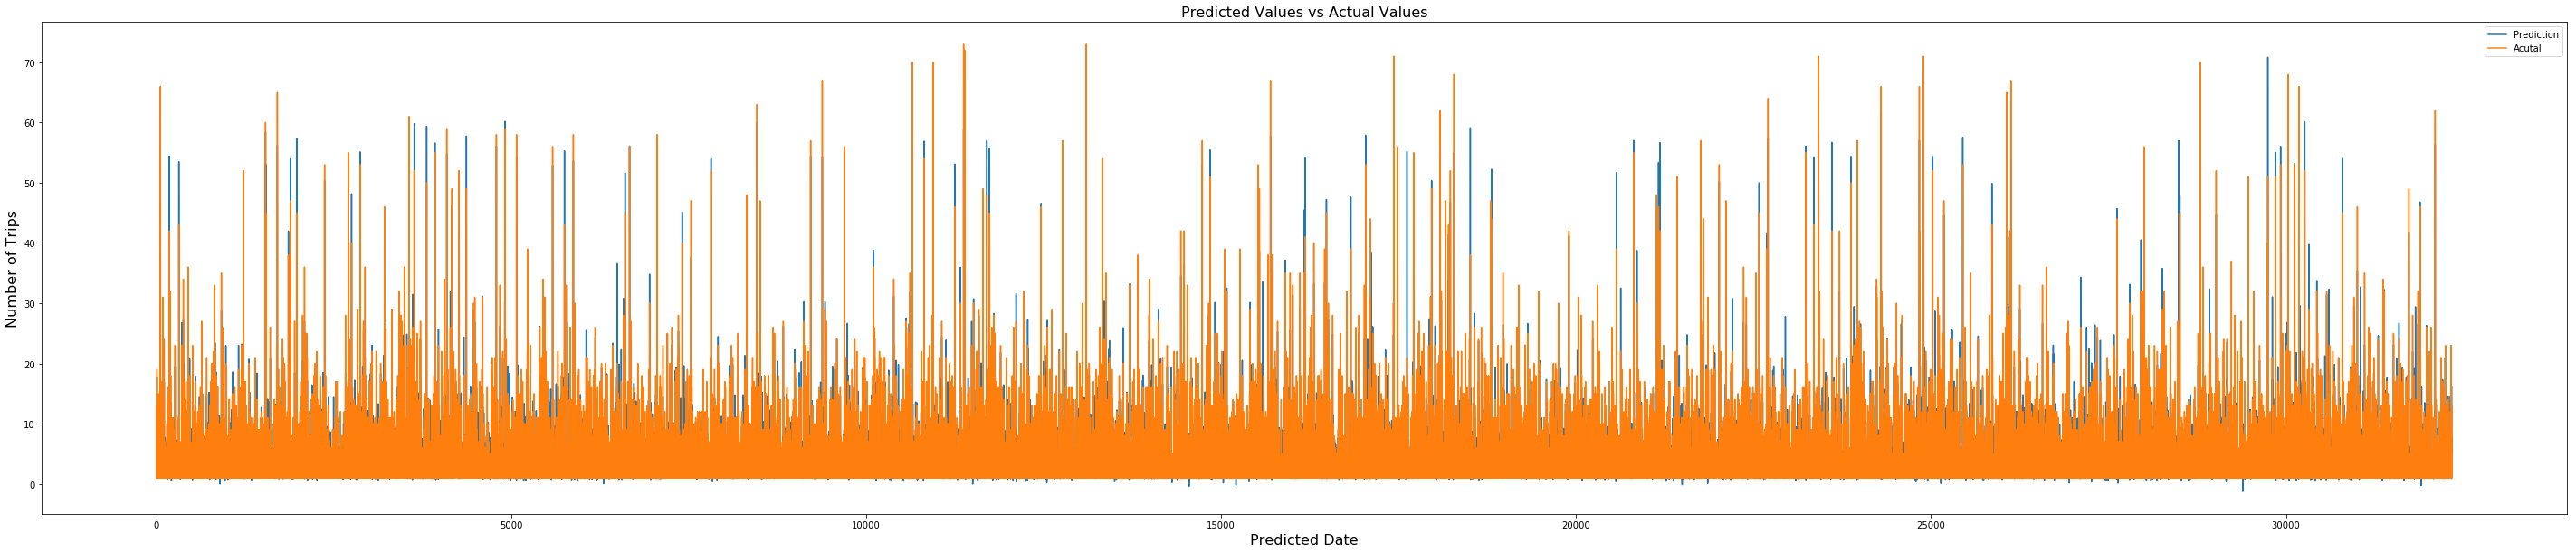

In [137]:
fs = 16
plt.figure(figsize=(50,10))
plt.plot(final_preds)
plt.plot(y_test)
plt.legend(['Prediction', 'Acutal'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Predicted Date", fontsize = fs)
plt.title("Predicted Values vs Actual Values", fontsize = fs)
plt.show()
# too much data point, hard to see
# need to find better way to plot

In [140]:
#Create a plot that ranks the features by importance.
def plot_importances(model, model_name):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for feature in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]    

    # Plot the feature importances of the forest
    plt.figure(figsize = (50,5))
    plt.title("Feature importances of " + model_name)
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

Feature ranking:
0 dock_count
1 max_temperature_f
2 mean_temperature_f
3 min_temperature_f
4 max_dew_point_f
5 mean_dew_point_f
6 min_dew_point_f
7 max_humidity
8 mean_humidity
9 min_humidity
10 max_sea_level_pressure_inches
11 mean_sea_level_pressure_inches
12 min_sea_level_pressure_inches
13 max_visibility_miles
14 mean_visibility_miles
15 min_visibility_miles
16 max_wind_Speed_mph
17 mean_wind_speed_mph
18 max_gust_speed_mph
19 precipitation_inches
20 cloud_cover
21 wind_dir_degrees
22 Fog
23 Fog-Rain
24 Normal
25 Rain
26 Rain-Thunderstorm
27 business_day
28 holiday
29 year
30 month
31 weekday
32 period 0
33 period 1
34 period 2
35 period 3
36 period 4
37 period 5
38 period 6
39 period 7
40 period 8
41 2
42 3
43 4
44 5
45 6
46 7
47 8
48 9
49 10
50 11
51 12
52 13
53 14
54 16
55 21
56 22
57 23
58 24
59 25
60 26
61 27
62 28
63 29
64 30
65 31
66 32
67 33
68 34
69 35
70 36
71 37
72 38
73 39
74 41
75 42
76 45
77 46
78 47
79 48
80 49
81 50
82 51
83 54
84 55
85 56
86 57
87 58
88 59
89 60
90

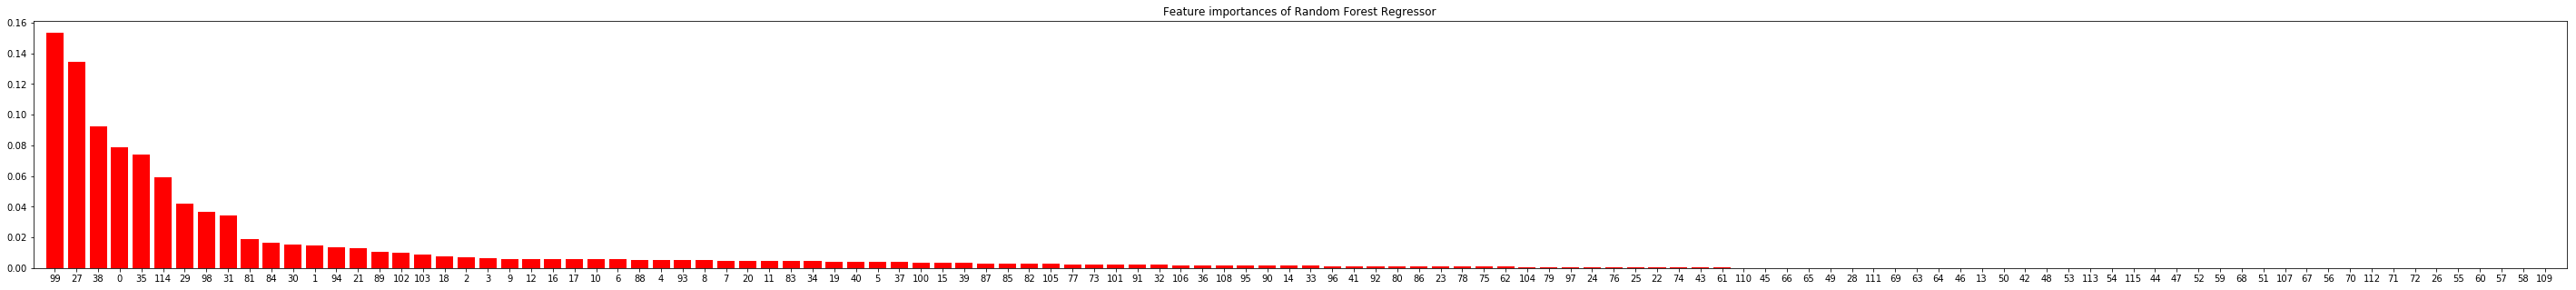

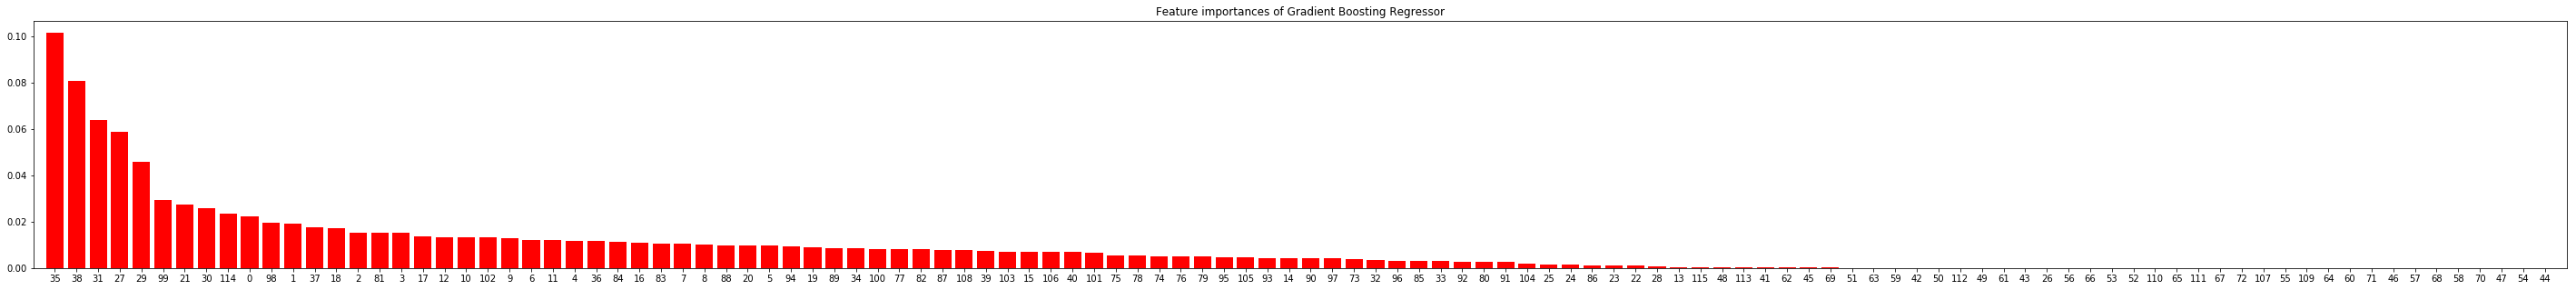

In [141]:
# Print the feature ranking
print("Feature ranking:")

i = 0
for feature in X_train:
    print (i, feature)
    i += 1
    
plot_importances(rfr, "Random Forest Regressor")
plot_importances(gbr, "Gradient Boosting Regressor")

For random forest model, top 10 important features are:
- 99: station id 70
- 27: business_day
- 38: period 6
- 0: dock_count
- 35: period 3
- 114: city = San Francisco
- 29: year
- 31: weekday

For gradient boosting model, top 10 important features are:
- 35: period 3
- 38: period 6
- 31: weekday
- 27: business_day
- 29: year
- 99: station id = 70
- 21: wind_dir_degrees
- 30: month
- 114: city = San Fransico
- 0: dock_count


# Observation
- top important features are very much consistent in different models
- weather is not an important factor in bike usage in Bay area (I believe the conclusion will be very different for Singapore)
- important factors like peak hours, business day, weekday are very predictable/known before hand --> future demand for bikes can be predicted at a very early time with high accuracy --> allow early planning (contrary to Singapore, if weather is an important factor, bike sharing companies can only predict demand for a few hours ahead, less planning time  --> this might be the reason that Singapore bike sharing companies have decided to adopt a dockless system)
- San Fransico has higher demand than other cities
- dock_count is an important factor --> this will only be the case when demand > #docks, which indicate to us that rebalancing is needed
- certain station ids appear as top 10 important features --> this indicate to us that demand at these stations are constantly higher regardless of day and time of the day --> constant rebalancing is required at these stations --> it will be interesting to see position of these few stations (id=70, 69, 50)


In [143]:
final_preds.shape

(32342,)

In [146]:
output = X_test

In [157]:
output["trips_actual"] = y_test.values
output["trips_predicted"] = final_preds

In [159]:
output

,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,82,83,84,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose,trips_actual,trips_predicted
124844,15,65.0,53.0,40.0,48.0,42.0,37.0,83.0,62.0,40.0,...,0,0,0,0,0,0,1,0,1,1.562526
120734,19,61.0,52.0,42.0,48.0,45.0,38.0,92.0,76.0,60.0,...,0,0,0,0,0,0,1,0,2,3.903488
125023,23,65.0,54.0,43.0,51.0,47.0,41.0,100.0,83.0,65.0,...,0,0,0,0,0,0,1,0,13,12.955348
36454,23,69.0,63.0,62.0,55.0,55.0,55.0,77.0,72.0,60.0,...,0,0,0,0,1,0,0,0,2,1.714266
97668,15,75.0,69.0,62.0,59.0,57.0,55.0,90.0,74.0,57.0,...,0,0,0,0,0,0,1,0,5,3.251653
32264,15,59.0,46.0,36.0,44.0,37.0,29.0,79.0,69.0,54.0,...,0,0,0,1,0,0,0,0,1,1.397794
94957,19,78.0,69.0,60.0,61.0,59.0,55.0,87.0,71.0,54.0,...,0,0,0,0,0,0,1,0,2,2.872821
54240,27,53.0,45.0,37.0,48.0,37.0,31.0,80.0,65.0,50.0,...,0,0,0,0,0,0,1,0,3,9.681378
55681,19,60.0,50.0,40.0,44.0,38.0,34.0,76.0,60.0,43.0,...,0,0,0,0,0,0,1,0,1,1.525972
103897,15,73.0,67.0,60.0,59.0,57.0,54.0,90.0,72.0,53.0,...,0,0,0,0,0,0,1,0,19,17.832087


In [166]:
output.to_csv("prediction output/Bike checkout prediction output.csv", encoding='utf-8', index=False)